In [1]:
import torch
import numpy as np
from torchvision import datasets
import tqdm

# Step 1: Test Forward Diffusion Process

Test the forward noising process q(x_t|x_0)

In [2]:
from ddpm_forward import ForwardDiffusion
from torchvision import transforms
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

forward_diffusion = ForwardDiffusion(
    timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    device=device
)

Using device: mps


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

print(f"Dataset loaded: {len(dataset)} images")

Dataset loaded: 60000 images


# Forward Noising Grid: 6 Samples Every 150 Steps

Show 6 clean digits and their progressive noising at 150-step intervals

In [4]:
# Get 6 different MNIST images
n_samples_forward = 6
forward_images = torch.stack([dataset[i][0] for i in range(n_samples_forward)]).to(device)

# Define timesteps to show (every 150 steps)
forward_timestep_interval = 150
forward_timesteps = list(range(0, 1000, forward_timestep_interval))

# Store noised images at each timestep
forward_noised_images = {}

for t_val in forward_timesteps:
    if t_val == 0:
        forward_noised_images[t_val] = forward_images.clone().cpu()
    else:
        t = torch.tensor([t_val] * n_samples_forward).to(device)
        noised = forward_diffusion.q_sample(forward_images, t)
        forward_noised_images[t_val] = noised.cpu()

print(f"Created noised versions at timesteps: {forward_timesteps}")

Created noised versions at timesteps: [0, 150, 300, 450, 600, 750, 900]


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

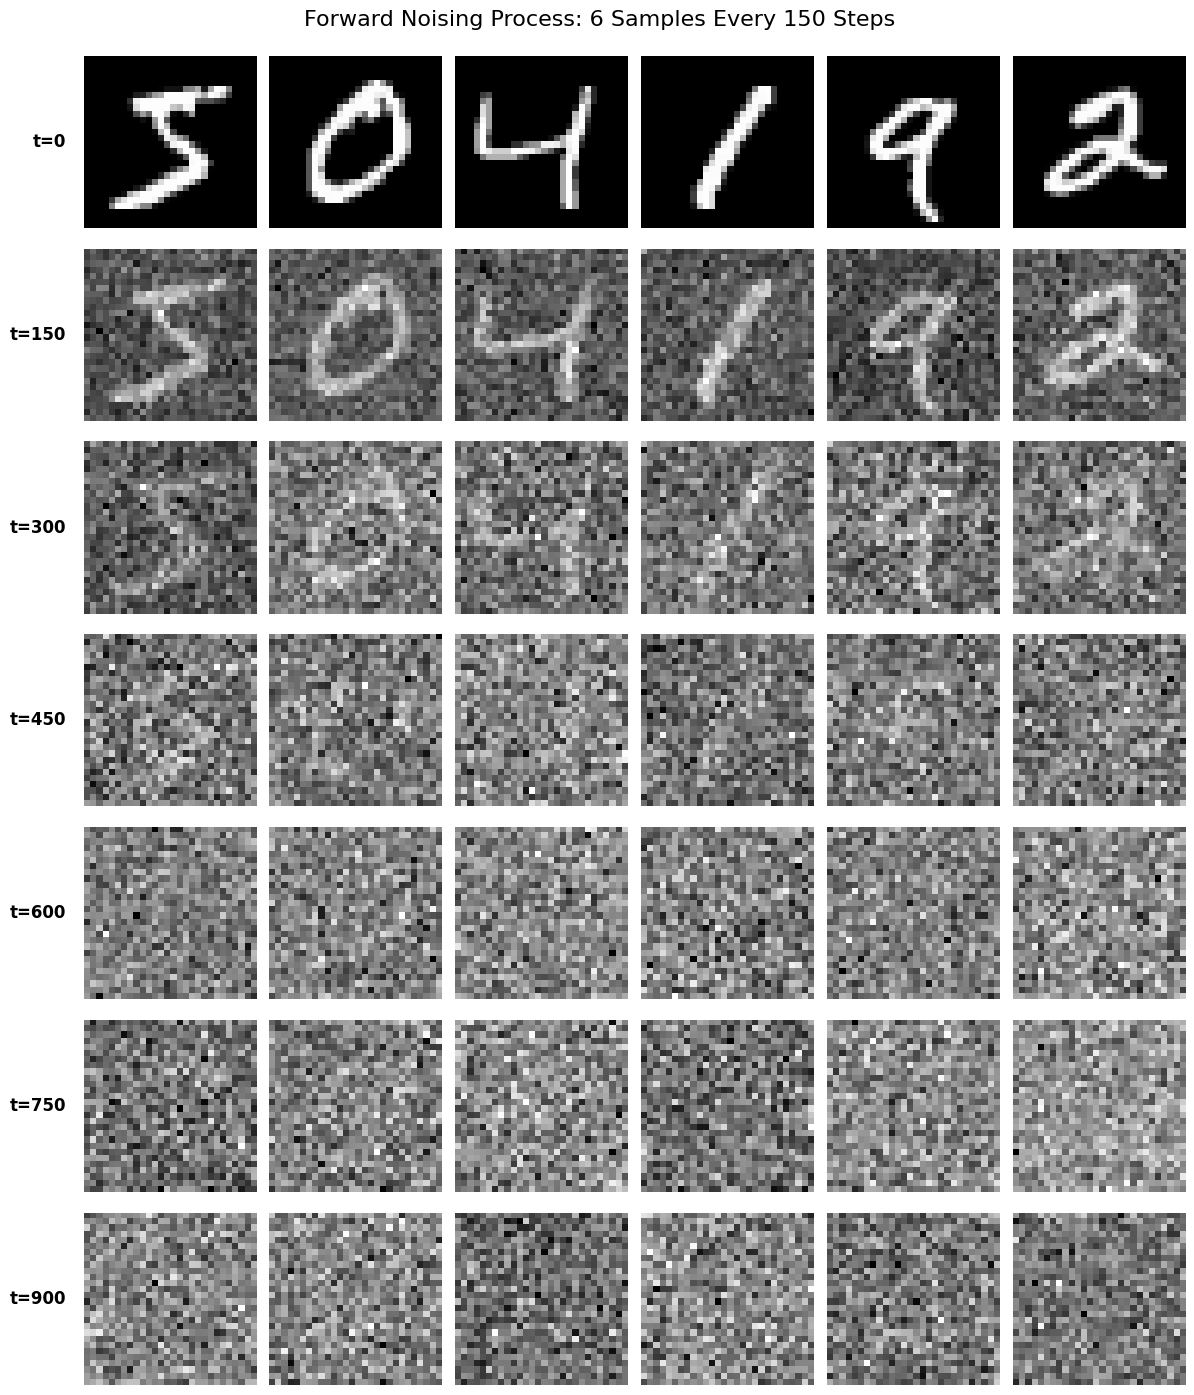

In [6]:
# Visualize the forward noising grid
n_rows_forward = len(forward_timesteps)
n_cols_forward = n_samples_forward

fig, axes = plt.subplots(n_rows_forward, n_cols_forward, figsize=(n_cols_forward * 2, n_rows_forward * 2))

for row_idx, t_val in enumerate(forward_timesteps):
    for col_idx in range(n_samples_forward):
        img = forward_noised_images[t_val][col_idx].squeeze().numpy()
        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')
        
        # Add timestep label on the left
        if col_idx == 0:
            axes[row_idx, col_idx].text(-0.1, 0.5, f't={t_val}', 
                                        transform=axes[row_idx, col_idx].transAxes,
                                        fontsize=12, fontweight='bold',
                                        va='center', ha='right')

plt.suptitle(f'Forward Noising Process: {n_samples_forward} Samples Every {forward_timestep_interval} Steps', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# Step 2: create U-Net Model

create the U-Net architecture that will predict noise ε_θ(x_t, t)

In [7]:
from unet_model import create_model

# Create the U-Net model
model = create_model(
    device=device,
    base_channels=128
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Step 3: Train the Model

Train the U-Net to predict noise using the simple loss function

In [ ]:
from train_ddpm import train_epoch, p_sample, p_sample_loop, visualize_trajectory, visualize_samples
from torch.utils.data import DataLoader
import torch.optim as optim

EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 2e-4

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

: 

In [ ]:
model.train()
losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    avg_loss = train_epoch(model, train_loader, optimizer, forward_diffusion, device)
    losses.append(avg_loss)
    print(f"Average Loss: {avg_loss:.4f}")


Epoch 1/20


Training: 100%|██████████| 469/469 [28:55<00:00,  3.70s/it, loss=0.0468]


Average Loss: 0.0569

Epoch 2/20


Training:  54%|█████▎    | 251/469 [16:18<14:09,  3.90s/it, loss=0.0378]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# Denoising Grid: 6 Samples Every 150 Steps

In [ ]:
import tqdm
# Generate 6 noise samples and denoise them step by step (every 150 timesteps)
model.eval()

n_samples = 6
timestep_interval = 200

# Start with pure noise
x = torch.randn(n_samples, 1, 28, 28).to(device)

# Store images at each interval
timesteps_to_save = list(range(999, -1, -timestep_interval)) + [0]
timesteps_to_save = sorted(set(timesteps_to_save), reverse=True)  # Remove duplicates and sort

saved_images = {t: None for t in timesteps_to_save}
saved_images[999] = x.clone().cpu()

# Denoise step by step
print(f"Denoising {n_samples} samples, saving every {timestep_interval} steps...")
current_x = x.clone()

for t_val in tqdm.tqdm(reversed(range(1000)), desc="Denoising", total=1000):
    t = torch.full((n_samples,), t_val, device=device, dtype=torch.long)
    current_x = p_sample(model, current_x, t, forward_diffusion)
    
    if t_val in timesteps_to_save:
        saved_images[t_val] = current_x.clone().cpu()

# Final result
saved_images[0] = current_x.clone().cpu()

print(f"Saved images at timesteps: {timesteps_to_save}")

In [ ]:
# Visualize the denoising grid
n_rows = len(timesteps_to_save)
n_cols = n_samples

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for row_idx, t_val in enumerate(timesteps_to_save):
    for col_idx in range(n_samples):
        img = saved_images[t_val][col_idx].squeeze().numpy()
        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')
        
        # Add timestep label on the left
        if col_idx == 0:
            axes[row_idx, col_idx].text(-0.1, 0.5, f't={t_val}', 
                                        transform=axes[row_idx, col_idx].transAxes,
                                        fontsize=12, fontweight='bold',
                                        va='center', ha='right')

plt.suptitle(f'Denoising Process: {n_samples} Samples Every {timestep_interval} Steps', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


# Step 4: Evaluation

In [ ]:
from evaluation import train_classifier, evaluate_generated_samples, compare_with_real_data

classifier = train_classifier(device=device, epochs=5)

In [ ]:
model.eval()
generated_for_eval = p_sample_loop(
    model,
    shape=(1000, 1, 28, 28),
    forward_diffusion=forward_diffusion,
    save_trajectory=False
)

print(f"Generated {generated_for_eval.shape[0]} samples")

In [ ]:
results = evaluate_generated_samples(
    generated_images=generated_for_eval,
    classifier=classifier,
    device=device
)

In [ ]:
baseline_confidence, baseline_confidences = compare_with_real_data(
    classifier=classifier,
    device=device,
    num_samples=1000
)


In [ ]:
# Visualize evaluation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confidence distribution
axes[0].hist(results['confidences'], bins=50, edgecolor='black', alpha=0.7, label='Generated')
axes[0].hist(baseline_confidences, bins=50, edgecolor='red', alpha=0.5, label='Real')
axes[0].axvline(results['avg_confidence'], color='blue', linestyle='--', linewidth=2, 
                label=f'Generated Mean: {results["avg_confidence"]:.3f}')
axes[0].axvline(baseline_confidence, color='red', linestyle='--', linewidth=2,
                label=f'Real Mean: {baseline_confidence:.3f}')
axes[0].set_xlabel('Classifier Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Confidence Distribution Comparison', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Class distribution
unique, counts = np.unique(results['predictions'], return_counts=True)
axes[1].bar(unique, counts, edgecolor='black', alpha=0.7)
axes[1].axhline(len(results['predictions'])/10, color='red', linestyle='--', linewidth=2, 
                label='Expected (uniform)')
axes[1].set_xlabel('Digit Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Generated Digit Classes', fontsize=14)
axes[1].set_xticks(range(10))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Evaluation complete!")
print(f"Overall Quality Score: {results['quality_score']:.4f}")